# NLP - classification of programming languages

In this project we will implement bag of words model for classification of programming languages based on source code. As classifier alghoritm we will use Random Forest.

In [2]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier
from nltk.tokenize import WordPunctTokenizer


In [1]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.20.1.


## Input data

First let's briefly explore our input data. 

In [3]:
df = pd.read_csv('data.csv')
df = df.sample(frac=1)
df[['language', 'file_body']].head(10)

,language,file_body
6949,C,#include <stdio.h>\n#include <ctype.h>\n#inclu...
15971,Perl,use utf8; # interpret source co...
5211,Ruby,">> ""She was a soul stripper. She took my heart..."
1970,Python,def recurse(counter):\n print(counter)\n cou...
1135,Swift,func isEven(n:Int) -> Bool {\n\n // Bitwise...
1418,Swift,let number = 1234\nlet base = 10\n\nprintln(...
13781,MATLAB,"fprintf(1,['<table>\n\t<tr>\n\t\t<th>',regexpr..."
2955,Python,"from pokerhand import Card, suit, face\nfrom i..."
1892,Python,import win32api\nimport win32con\nimport win32...
9450,Go,switch {\ncase booleanExpression1:\n statem...


#### Preprocessing

Before we will build our model, we have to perform preprocessing of input data. We want to clean our corpus from text which is redundant and it does not matter in context of language recognition. That kind of redundant data may introduce unnecessery noise and as consequence our model may overfit training data. To clean dataset we will perform 4 operations:

    - remove comments
    - remove digits
    - replace content inside quotes with hardcoded string
    - remove tabs and new lines

In [4]:
def clean_dataset(df):
    # Remove comments starting with type of //comment and /* comment */
    for lang in {'JavaScript', 'Java', 'Swift', 'C++', 'Rust', 'C', 'Scala','Go', 'Kotlin', 'PHP', 'Perl'}: 
        df.loc[df['language']==lang,'file_body'] = df[df['language']==lang]['file_body'].str.replace(re.compile("/\*.*?\*/",re.DOTALL ) ,"" ,regex=True)
        df.loc[df['language']==lang,'file_body'] = df[df['language']==lang]['file_body'].str.replace(re.compile("//.*?\n" ) ,"" ,regex=True)
    for lang in {'Python', 'Ruby', 'R', 'Julia'}:
        df.loc[df['language']==lang,'file_body'] = df[df['language']==lang]['file_body'].str.replace(re.compile("#.*?\n" ) ,"" ,regex=True)
    for lang in {'MATLAB'}:
        df.loc[df['language']==lang,'file_body'] = df[df['language']==lang]['file_body'].str.replace(re.compile("%.*?\n" ) ,"" ,regex=True)
    for lang in {'Haskell'}:
        df.loc[df['language']==lang,'file_body'] = df[df['language']==lang]['file_body'].str.replace(re.compile("--.*?\n" ) ,"" ,regex=True)
    
    # Remove digits
    df['file_body'] = df['file_body'].str.replace(re.compile('\d+(.\d+)?'), "CYFRA", regex=True)
   
    # Replace content inside quotes with hardcoded string
    df['file_body'] = df['file_body'].str.replace(re.compile('".*?"') ,"SLOWO" ,regex=True)
    df['file_body'] = df['file_body'].str.replace(re.compile("'.*?'") ,"SLOWO" ,regex=True)
    
    # Remove tabs and new lines
    df['file_body'] = df['file_body'].str.replace(re.compile('\n|\t') ," " ,regex=True)
    
    return df

#### Load and visualise data

In [ ]:
Helper function for visualisation

In [5]:
def basicVisualization(df):
    # Visualization
    order = list(df['language'].unique())
    order.sort()
    
    fig, axs = plt.subplots(nrows = 2, figsize=(20, 10))
    sns.countplot(x="language", data=df, ax = axs[0], order = order)
    sns.barplot(x = df.groupby('language').agg('median').index, y ='body_len', data=df.groupby('language').agg('median'), ax = axs[1])
    axs[0].set_title('Number of samples per language')
    axs[0].set_ylabel('Number of samples')
    axs[1].set_title('Median body lenght per language')
    axs[1].set_ylabel('Median value of body lenght')

Define function to load input data, clean it and add new column of file length. This column will be used only for visualisation.

In [6]:
def load_input_data():
    # Read dataset
    df = pd.read_csv('data.csv')
    df['body_len'] = df['file_body'].apply(str).apply(len)
    
    # Data Engineering
    df = clean_dataset(df)
    
    return df

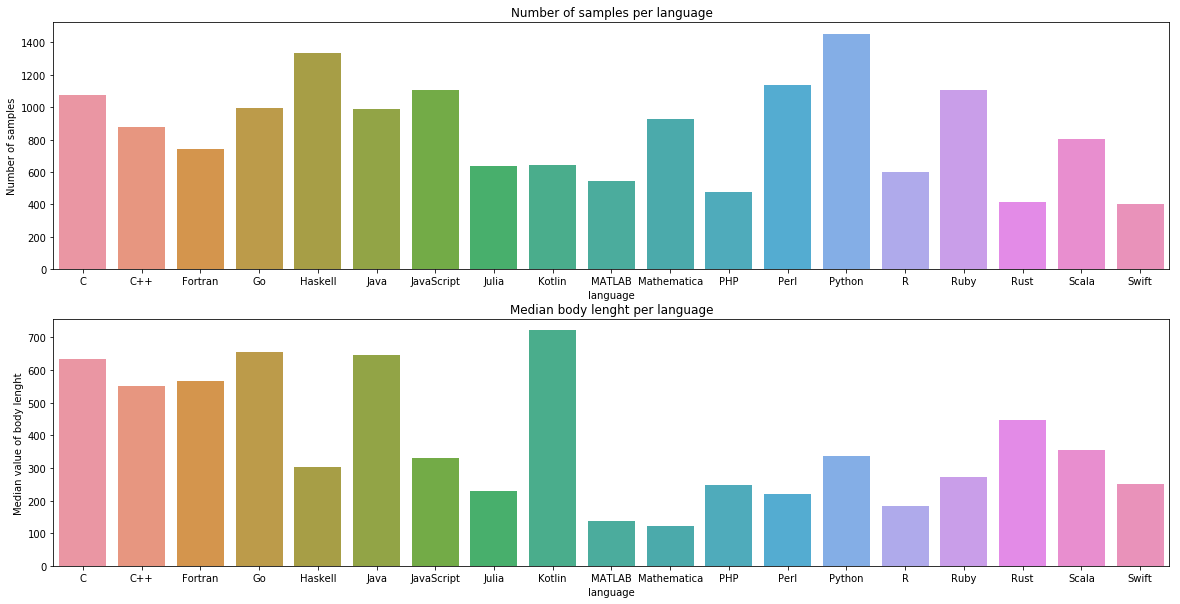

In [7]:
df = load_input_data()
basicVisualization(df)

As we can see, number of samples per language is balanced enough but median body length is quite small for few languages. We will try to build model despite that, and in case of not satisfing results we will make our input data more balanced.

## Model

Now let's build our bag of words model and use Random Forest alghoritm for classification. 
First encode languages into numeric values.

In [8]:
# Encode languages values in dataset and shuffle data
lb = LabelEncoder()
df['language'] = lb.fit_transform(df['language'].values)
df = df.sample(frac=1)

We are building bag of words for 1500 most frequent words. For tokenization we will use WordPunctTokenizer which will extract special sings as separate tokens. This will be useful for our model because sings like: ";", "#", ">" may be important. 
We will use TfidfTransformer to normalize our count matrix. The goal of using tf-idf instead of the raw frequencies of occurrence of a token in a given document is to scale down the impact of tokens that occur very frequently in a given corpus and that are hence empirically less informative than features that occur in a small fraction of the training corpus.

In [9]:
def my_tokenizer(doc):
    # Use WordPunctTokenizer to split text into tokens
    my_tokenizer = WordPunctTokenizer()
    
    return my_tokenizer.tokenize(doc)
    
    
def create_bag_of_words_model(df):
   #Create bag of words model 
   vectorizer = CountVectorizer(tokenizer = my_tokenizer, max_features = 1500)
   bag_of_words = vectorizer.fit_transform(df['file_body'].values.astype('U'))
   tfidf_transformer = TfidfTransformer(use_idf=False).fit(bag_of_words)
   bag_of_words_norm = tfidf_transformer.transform(bag_of_words).toarray()
   vocab = vectorizer.get_feature_names() 
   
   return vocab, bag_of_words_norm

In [10]:
# Build bag of words model 
vocab, bag_of_words = create_bag_of_words_model(df)

## Training

Before training we will split data into training set and test set in proportion 4:1

In [11]:
X_train, X_test, y_train, y_test = train_test_split(bag_of_words, df['language'].values, test_size = 0.20, random_state = 0)

For calssification we will use Random Forest alghoritm, in declaration of classifier we define only number of decission trees which will be used.

In [12]:
def train_model(X_train, y_train, X_test, y_test):
    # Train model with Random Forest Classifier
    classifier = RandomForestClassifier(n_estimators = 200)
    classifier.fit(X_train, y_train)

    #Predict values for test set
    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    return y_pred, accuracy

In [13]:
# Train model
y_pred, accuracy = train_model(X_train,y_train, X_test, y_test)

Presentation of results

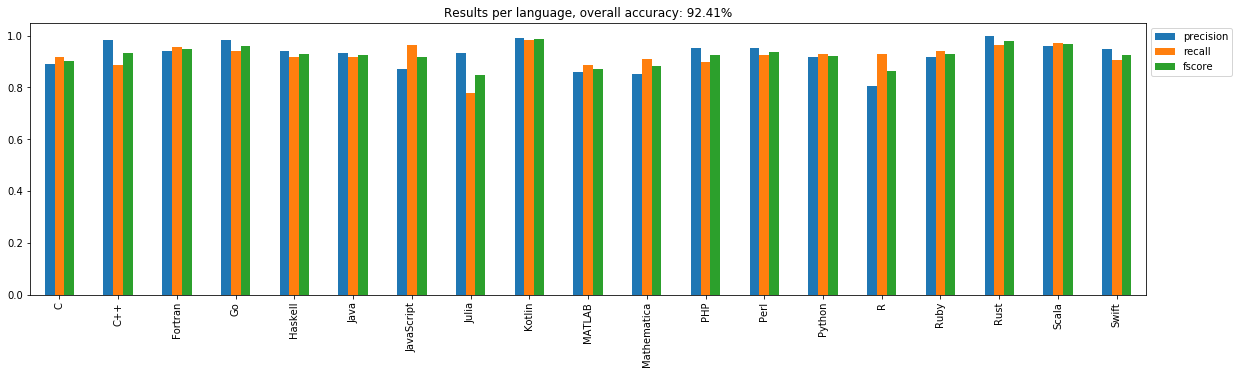

In [14]:
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred)
results = pd.DataFrame( data={'precision': precision, 'recall': recall, 'fscore': fscore})
results.index = lb.inverse_transform(results.index)
results.plot( kind="bar", figsize = (20, 5), title = 'Results per language, overall accuracy: '+"{:.2%}".format(accuracy)).legend(bbox_to_anchor=(1, 1))